In [202]:

import pandas as pd
import numpy as np
import pandas_datareader as web
from matplotlib import pyplot as plt
%matplotlib inline
#plt.style.use('fivethirtyeight') 

<AxesSubplot:xlabel='Date', ylabel='Adjusted Closing Price Over Time'>

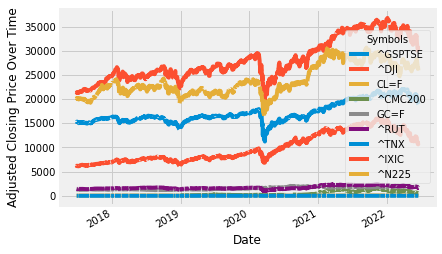

In [203]:
symbols = ['^GSPTSE',
'^DJI',
'CL=F',
#'BTC-CAD',
'^CMC200',
'GC=F',
'^RUT',
'^TNX',
'^IXIC',
'^N225'
]

from datetime import datetime, timedelta
start =  datetime.today() - timedelta(weeks=52*5) #Last 5 years
#print(start)
end = datetime.today()
#print(end)

stock_data = web.get_data_yahoo(symbols, start, end)
#print(stock_data.head())
stock_data["Adj Close"].plot(ylabel="Adjusted Closing Price Over Time")

d:\Users\Ben\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


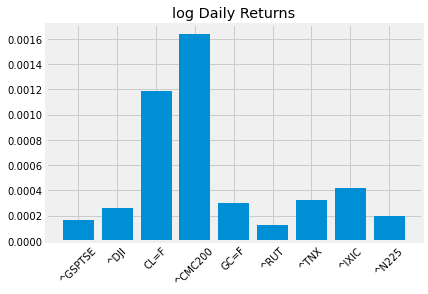

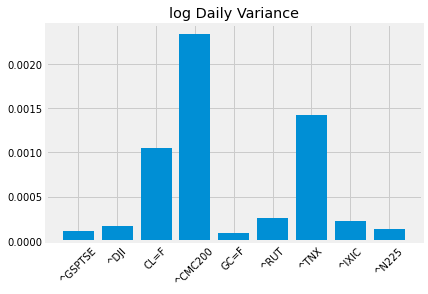

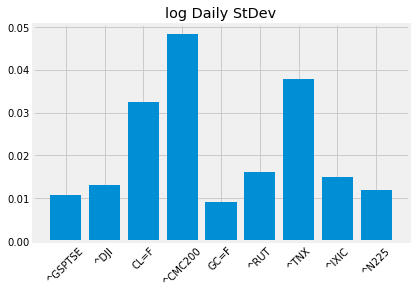

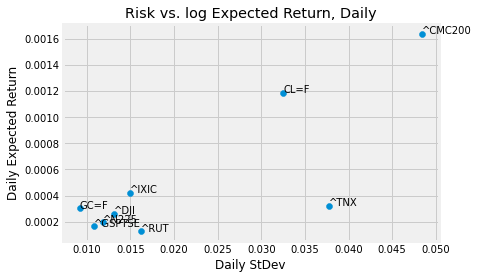

<AxesSubplot:xlabel='Symbols', ylabel='Symbols'>

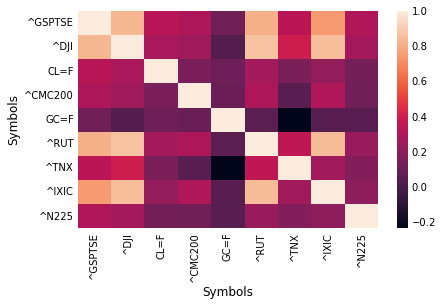

In [204]:
import seaborn as sns

stock_data_daily_pct = stock_data["Adj Close"].pct_change().apply(lambda x: np.log(1+x))
#stock_data_daily_pct.plot(alpha = 0.5)

daily_mean = stock_data_daily_pct.mean()   
#print(daily_mean)
plt.bar(x = daily_mean.index, height = daily_mean)
plt.xticks(rotation = 45)
plt.title("log Daily Returns")
plt.show()

daily_variance = stock_data_daily_pct.var()
#print(daily_variance)
plt.bar(x = daily_variance.index, height = daily_variance)
plt.xticks(rotation = 45)
plt.title("log Daily Variance")
plt.show()

daily_stdev = stock_data_daily_pct.std()
#print(daily_stdev)
plt.bar(x = daily_stdev.index, height = daily_stdev)
plt.xticks(rotation = 45)
plt.title("log Daily StDev")
plt.show()

plt.scatter(x = daily_stdev, y = daily_mean)
for i, symbol in enumerate(symbols):
    plt.annotate(symbol, (daily_stdev[i], daily_mean[i]))
plt.title("Risk vs. log Expected Return, Daily")
plt.xlabel("Daily StDev")
plt.ylabel("Daily Expected Return")
plt.show()

stock_corr = stock_data_daily_pct.corr()
sns.heatmap(stock_corr)

In [205]:
import pypfopt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

portfolio = stock_data["Adj Close"]
total_portfolio_value = 1000000
#print(portfolio.head())

#mean-variance optimization
mean_return = mean_historical_return(portfolio)
cov_shrinkage = CovarianceShrinkage(portfolio).ledoit_wolf()

from pypfopt.efficient_frontier import EfficientFrontier

efficient_frontier = EfficientFrontier(mean_return, cov_shrinkage)
weights = efficient_frontier.max_sharpe()
clean_weights = efficient_frontier.clean_weights()
#print(dict(clean_weights))
efficient_frontier.portfolio_performance(verbose=True)

final_portfolio_df = pd.DataFrame({'ticker': clean_weights.keys(), 'weights': clean_weights.values()})
#print(final_portfolio_df)

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(portfolio)
final_portfolio_df["latest_prices"] = pd.array(latest_prices)
#print(final_portfolio_df)

discrete_alloc = DiscreteAllocation(weights, latest_prices, total_portfolio_value = total_portfolio_value)
alloc, leftover = discrete_alloc.greedy_portfolio()

total_value = 0
for key in alloc:
    total_value += alloc[key]*latest_prices[key]
    print(key)
#print(total_value)

final_portfolio_df["discrete_alloc"] = round((final_portfolio_df["weights"]*total_portfolio_value)/final_portfolio_df["latest_prices"],0)
final_portfolio_df["total_value"] = round(final_portfolio_df["discrete_alloc"]*final_portfolio_df["latest_prices"], 2)

print("Used Funds: ${:.2f}".format(total_value), "Funds remaining: ${:.2f}".format(leftover))
print(final_portfolio_df)    
#print(final_portfolio_df.total_value.sum())
#print("Discrete allocation:", alloc)

#final_portfolio_df.to_csv('final_portfolio.csv')


Expected annual return: 33.2%
Annual volatility: 38.0%
Sharpe Ratio: 0.82
^CMC200
^IXIC
GC=F
CL=F
^TNX
^DJI
^N225
^GSPTSE
Used Funds: $999933.88 Funds remaining: $66.12
    ticker  weights  latest_prices  discrete_alloc  total_value
0  ^GSPTSE  0.00902   18930.480469             0.0         0.00
1     ^DJI  0.04790   29888.779297             2.0     59777.56
2     CL=F  0.06919     110.480003           626.0     69160.48
3  ^CMC200  0.56123     438.004486          1281.0    561083.75
4     GC=F  0.09481    1841.900024            51.0     93936.90
5     ^RUT  0.00000    1665.693604             0.0         0.00
6     ^TNX  0.06115       3.239000         18879.0     61149.08
7    ^IXIC  0.11799   10798.349609            11.0    118781.85
8    ^N225  0.03871   25963.000000             1.0     25963.00


In [208]:
#Heirarchical Risk parity

from pypfopt import HRPOpt
returns = portfolio.pct_change().dropna()
hrp = HRPOpt(returns)
hrp_weights = hrp.optimize()

hrp.portfolio_performance(verbose=True)
print(dict(hrp_weights))
da_hrp = DiscreteAllocation(hrp_weights, latest_prices, total_portfolio_value)
hrp_alloc, hrp_leftover = da_hrp.greedy_portfolio()
total_value = 0
for key in hrp_alloc:
    total_value += hrp_alloc[key]*latest_prices[key]
print("Discrete Allocation: ", hrp_alloc)
print("Used Funds: ${:.2f}".format(total_value), "Funds remaining: ${:.2f}".format(hrp_leftover))

Expected annual return: 12.1%
Annual volatility: 12.4%
Sharpe Ratio: 0.82
{'CL=F': 0.0033379772946280344, 'GC=F': 0.4367822484406696, '^CMC200': 0.0175945272401056, '^DJI': 0.03808389594365715, '^GSPTSE': 0.09551124170240335, '^IXIC': 0.09222266246666783, '^N225': 0.28075663211124907, '^RUT': 0.023774313333344177, '^TNX': 0.011936501467275158}
Discrete Allocation:  {'GC=F': 237, '^N225': 11, '^GSPTSE': 5, '^IXIC': 9, '^DJI': 1, '^RUT': 14, '^CMC200': 40, '^TNX': 3686, 'CL=F': 30}
Used Funds: $999942.88 Funds remaining: $57.12


In [218]:
#Mean Conditional Value at Risk

from pypfopt.efficient_frontier import EfficientCVaR
cov = portfolio.cov()
ef_cvar = EfficientCVaR(mean_return, cov)
cvar_weights = ef_cvar.min_cvar()
clean_weights = ef_cvar.clean_weights()
print(dict(clean_weights))
da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value=total_portfolio_value)
cvar_alloc, cvar_leftover = da_cvar.greedy_portfolio()
ef_cvar.portfolio_performance(verbose=True)
print("Discrete allocation (CVAR):", cvar_alloc)
print("Funds remaining (CVAR): ${:.2f}".format(cvar_leftover))

{'^GSPTSE': 0.0, '^DJI': 0.0, 'CL=F': 1.0, '^CMC200': 0.0, 'GC=F': 0.0, '^RUT': 0.0, '^TNX': 0.0, '^IXIC': 0.0, '^N225': 0.0}
Expected annual return: 20.0%
Conditional Value at Risk: -700.92%
Discrete allocation (CVAR): {'CL=F': 9051, '^TNX': 1}
Funds remaining (CVAR): $42.25
